In [1]:
!pip install swig
!pip install gymnasium
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 37.6 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373126 sha256=298f508b2f92408460e6a75756ba62f6ecee68d139fe0874b336a370e83b437e
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [12]:
import gymnasium as gym
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [4]:
# device will be 'cuda' if a GPU is available
device = T.device('cuda' if T.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
Transition = namedtuple('Transition',  ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # Store transition in buffer memory
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        # Return random samples from the buffer for training
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [19]:
# Define the model for the neural network
# Simple feed forward network with ReLu activation

class DQN(nn.Module):

  def __init__(self, hidden_units, num_observations, num_actions):
    super().__init__()
    self.fc1 = nn.Linear(num_observations, hidden_units) # Input is state observation
    self.av1 = nn.ReLU()
    self.fc2 = nn.Linear(hidden_units, hidden_units)
    self.av2 = nn.ReLU()
    self.fc3 = nn.Linear(hidden_units, hidden_units)
    self.av3 = nn.ReLU()
    self.fc4 = nn.Linear(hidden_units, num_actions) # Output layer is avaiable actions

    return

  def forward(self, x):
    x = self.fc1(x)
    x = self.av1(x)
    x = self.fc2(x)
    x = self.av2(x)
    x = self.fc3(x)
    x = self.av3(x)
    x = self.fc4(x)
    return x


In [20]:
env = gym.make("LunarLander-v2")

In [21]:
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
hidden_units = 128

# number of actions
num_actions = env.action_space.n
# number of state observations
state, info = env.reset()
num_observations = len(state)

policy_net = DQN(hidden_units, num_observations, num_actions).to(device)
target_net = DQN(hidden_units, num_observations, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayBuffer(10000)


time_step = 0

def select_action(state, train=True):
  if train:
    global time_step
    random_sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * time_step / EPS_DECAY)
    time_step += 1
    # epsilon greedy to select action from the policy network
    if random_sample > eps_threshold:
        with T.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return T.tensor([[env.action_space.sample()]], device=device, dtype=T.long)
  else:
    return policy_net(state).max(1)[1].view(1, 1)

episode_durations = []
episode_rewards = []


In [9]:
def plot_rewards(show_result=False):
    plt.figure(figsize=(10, 6))
    rewards_t = T.tensor(episode_rewards, dtype=T.float)
    if show_result:
        plt.title('Performance Result for DQN-Agent')
    else:
        plt.clf()
        plt.title('Training DQN-Agent ...')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.plot(rewards_t.numpy(), label='Q Agent', marker='o')
    # Plot also 100 episode averages
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = T.cat((T.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [22]:
def optimize_policy():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states
    non_final_mask = T.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=T.bool)
    non_final_next_states = T.cat([s for s in batch.next_state if s is not None])
    state_batch = T.cat(batch.state)
    action_batch = T.cat(batch.action)
    reward_batch = T.cat(batch.reward)

    # Compute Q(s, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s) for all next states.
    next_state_values = T.zeros(BATCH_SIZE, device=device)
    with T.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    T.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [23]:
timesteps = 1000
moving_average_window = 20
n_episodes = 50
step_size = 20

if T.cuda.is_available():
    n_episodes = 1000

episode_numbers = []
moving_average_rewards = []

last_n_rewards = []  # To keep the rewards of the last MA episodes

for episode in range(1, n_episodes + 1):
    # Reset the environment and get the initial state
    state, info = env.reset()
    state = T.tensor(state, dtype=T.float32, device=device).unsqueeze(0)
    G = 0

    for _ in range(timesteps):
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        G += reward
        reward = T.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = T.tensor(observation, dtype=T.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        state = next_state
        # Perform one step of the optimization (on the policy network)
        optimize_policy()

        # Soft update of the target network's weights
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # episode_durations.append(t + 1)
            episode_rewards.append(G)
            break

    last_n_rewards.append(G)

    if len(last_n_rewards) > moving_average_window:
        last_n_rewards.pop(0)

    moving_average = np.mean(last_n_rewards)

    if episode % step_size == 0:
        episode_numbers.append(episode)
        moving_average_rewards.append(moving_average)
        print(f"Episode {episode} completed. Moving Average Reward over last {moving_average_window} episodes: {moving_average}")


Episode 20 completed. Moving Average Reward over last 20 episodes: -174.19917430427978
Episode 40 completed. Moving Average Reward over last 20 episodes: -173.4791393801278
Episode 60 completed. Moving Average Reward over last 20 episodes: -139.31670089706623
Episode 80 completed. Moving Average Reward over last 20 episodes: -92.18181950431156
Episode 100 completed. Moving Average Reward over last 20 episodes: -94.66780344368615
Episode 120 completed. Moving Average Reward over last 20 episodes: -81.76246461025717
Episode 140 completed. Moving Average Reward over last 20 episodes: -66.16333714580284
Episode 160 completed. Moving Average Reward over last 20 episodes: -72.72515597968592
Episode 180 completed. Moving Average Reward over last 20 episodes: -35.61160084611621
Episode 200 completed. Moving Average Reward over last 20 episodes: -46.00718018818561
Episode 220 completed. Moving Average Reward over last 20 episodes: -20.58333172946537
Episode 240 completed. Moving Average Reward 

<Figure size 640x480 with 0 Axes>

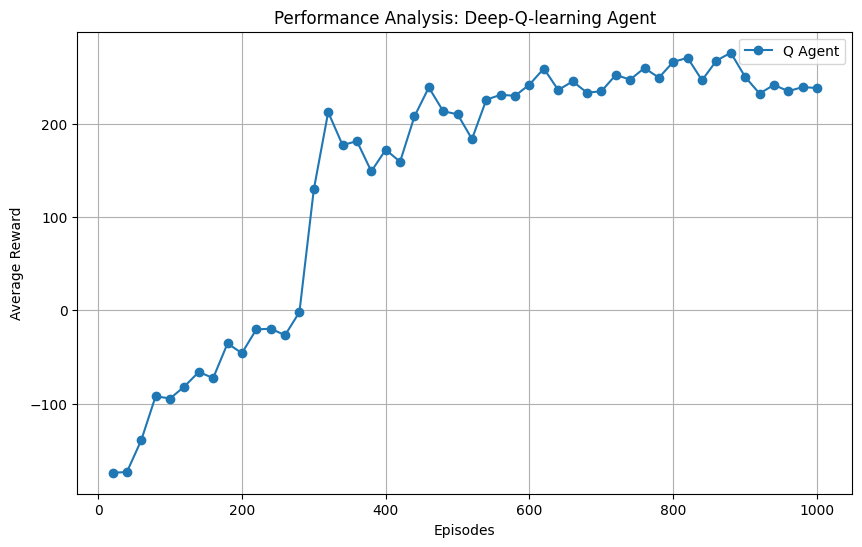

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(episode_numbers, moving_average_rewards, label='Q Agent', marker='o')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Performance Analysis: Deep-Q-learning Agent')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Test the optimized policy
import cv2
import os

env = gym.make("LunarLander-v2", render_mode="rgb_array")

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('DQN_gameplay.avi', fourcc, 30.0, (600, 400))

for i in range(1,2):
    score = 0
    state, info = env.reset()

    state = T.tensor(state, dtype=T.float32, device=device).unsqueeze(0)

    while True:
        env.render()
        frame = env.render()
        out.write(frame)

        action = select_action(state, train=False)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = T.tensor(observation, dtype=T.float32, device=device).unsqueeze(0)

        state = next_state
        score += reward

        if done:
            break
    print(f'Episode: {i} Reward: {score}'.format(i, score))

out.release()
env.close()


Episode: 1 Reward: 219.52606632234247
